In [8]:
%matplotlib inline
import openmc
import os 
os.environ['OPENMC_CROSS_SECTIONS']='/home/dresden/endfb-viii.0-hdf5/cross_sections.xml'
import math
import numpy as np
from matplotlib import pyplot

uo2=openmc.Material()
uo2.add_nuclide('U235', 0.03)
uo2.add_nuclide('U238', 0.97)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.0)

zirconium = openmc.Material(name="zirconium")
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)

gas =openmc.Material()
gas.add_element("He",percent=1)
gas.set_density('g/cm3',0.178*10**-3)

water = openmc.Material(name="h2o")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)

water.add_s_alpha_beta('c_H_in_H2O')

materials = openmc.Materials([uo2, zirconium, water,gas])

materials.export_to_xml()

/usr/local/lib/python3.10/dist-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=1.
  warn(msg, IDWarning)


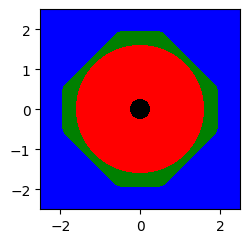

In [9]:
import numpy as np
"""geometry """
cylinder2=openmc.ZCylinder(r=2)
cylinder0=openmc.ZCylinder(r=0.25)
cylinder1=openmc.ZCylinder(r=1.6)
plane1=openmc.Plane(a=1,b=1,c=0,d=2.5)
plane2=openmc.Plane(a=1,b=1,c=0,d=-2.5)
plane3=openmc.Plane(a=1,b=-1,c=0,d=2.5)
plane4=openmc.Plane(a=1,b=-1,c=0,d=-2.5)
plane5=openmc.Plane(a=0,b=1,c=0,d=1.95)
plane6=openmc.Plane(a=0,b=1,c=0,d=-1.95)
plane7=openmc.Plane(a=1,b=0,c=0,d=1.95)
plane8=openmc.Plane(a=1,b=0,c=0,d=-1.95)
lattice=openmc.rectangular_prism(5,5,boundary_type='reflective')

_0cell=openmc.Cell(name="gas",region=-cylinder0,fill=gas)
_0_cell=openmc.Cell(name="gas",region=-cylinder1 & +cylinder0,fill=uo2)
_1cell=openmc.Cell(name='fuel',region=-cylinder2 & + cylinder1 & -plane1 & +plane2 & -plane3 & +plane4 & -plane5 & +plane6  & -plane7 & +plane8,fill=zirconium)
_2cell=openmc.Cell(name='water1',region=+cylinder1 & lattice,fill=water)
_3cell=openmc.Cell(name='water2',region=+plane1 & -plane2 & +plane3 & -plane4 & +plane5 & -plane6 & +plane7 & -plane8, fill=water)
root=openmc.Universe(universe_id=1,name="pin cell")
root.add_cells([_0_cell,_0cell,_1cell,_2cell,_3cell])

geometry = openmc.Geometry(root)
geometry.export_to_xml()

root.plot(width=(5,5),color_by='material',colors={uo2:'red',water:'blue',gas:'black',zirconium:'green'})

source = openmc.Source(space=src_pnt, energy=src_energy)

settings = openmc.Settings()

settings.batches = 10
settings.particles = 100
settings.export_to_xml()

# Create equal-lethargy energies to put in filter
energies = np.logspace(np.log10(1e-5), np.log10(20.0e6), 501)
e_filter = openmc.EnergyFilter(energies)
tallies = openmc.Tallies()
# Create tally with energy filter
tally = openmc.Tally()
tally.filters = [e_filter]
tally.scores = ['flux']
# Create energy filter using SHEM-361 group structure
energies_shem = openmc.mgxs.GROUP_STRUCTURES['SHEM-361']
shem_filter = openmc.EnergyFilter(openmc.mgxs.GROUP_STRUCTURES['SHEM-361'])

tally_shem = openmc.Tally()
tally_shem.filters = [shem_filter]
tally_shem.scores = ['flux']
tallies.append(tally)
tallies.export_to_xml()



In [10]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [14]:
with openmc.StatePoint("statepoint.10.h5") as sp:
    t = sp.tallies[7]
    flux500_mean = t.mean.ravel()
    flux500_unc = t.std_dev.ravel()
    
    t_shem = sp.tallies[7]
    flux_shem_mean = t_shem.mean.ravel()
    flux_shem_unc = t_shem.std_dev.ravel()

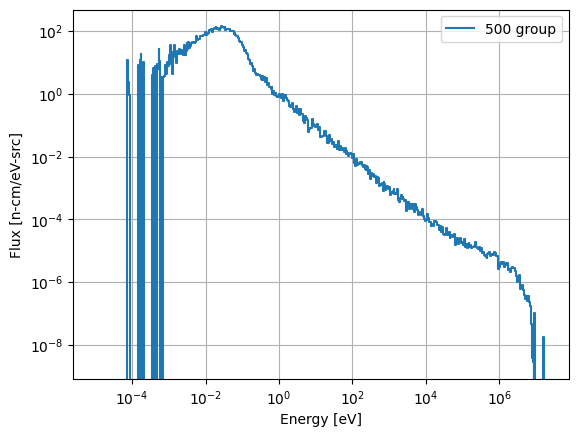

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.step(energies[:-1], flux500_mean/np.diff(energies), where='post', label='500 group')
#ax.step(energies_shem[:-1], flux_shem_mean/np.diff(energies_shem), where='post', label='SHEM-361')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Flux [n-cm/eV-src]')
ax.grid()
ax.legend()

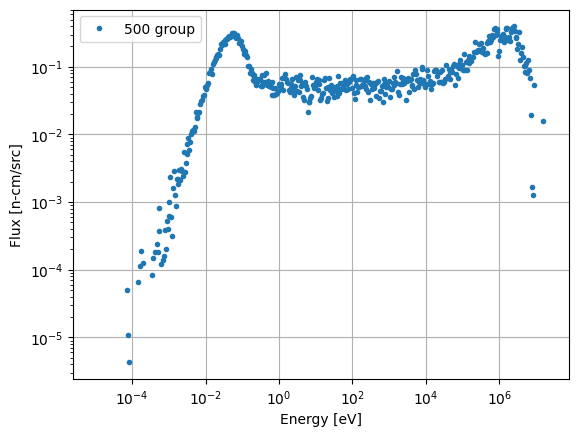

In [18]:
fig, ax = plt.subplots()
ax.loglog(energies[:-1], flux500_mean, '.', color='C0', label='500 group')
#ax.loglog(energies_shem[:-1], flux_shem_mean, '.', color='C1', label='SHEM-361')
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Flux [n-cm/src]')
ax.grid()
ax.legend()